# Grade: /100 pts
# Assignment 9: FATE Machine Learning

## Student ID: 25083697

In this coursework, we will study how to make a complex non-linear model more interpretable and we will study any fairness issues that may arise when using AI models to solve organizational problems.

Our problem will be credit card default prediction, a well-known application of machine learning that most financial institutions and payment processors deploy to decide creditworthiness. Normally, financial institutions use linear models such as logistic regression to create these models, but non-linear (and less explainable) methods are tempting as they have strong predictive abilities. In this coursework, we'll create one of such models and study what issues arise. The following questions first develop a model, then we study how to make it more interpretable, and finally, we discuss any fairness issues that arise.

In [1]:
# Install SHAP if needed
# !pip install shap

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve,roc_auc_score

from xgboost import XGBClassifier
import shap

C:\Users\angel\anaconda3\envs\ds3000\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# Download the data directly
# !gdown https://drive.google.com/uc?id=1sqKxJeJhLA2BaEVnCqXcLWZ5oSfyVP56

For this assignment, we will use a credit card default dataset. For further information about the data, refer to: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

**Variable explanations:**

**ID:** ID of each client.

**LIMIT_BAL:** Amount of given credit in NT dollars (includes individual and family/supplementary credit).

**SEX:** Gender reported to the company (1=male, 2=female).

**EDUCATION:** (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown).

**MARRIAGE:** Marital status (1=married, 2=single, 3=others).

**AGE:** Age in years.

**PAY_0:** Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above).

**PAY_2:** Repayment status in August, 2005 (scale same as above).

**PAY_3:** Repayment status in July, 2005 (scale same as above).

**PAY_4:** Repayment status in June, 2005 (scale same as above).

**PAY_5:** Repayment status in May, 2005 (scale same as above).

**PAY_6:** Repayment status in April, 2005 (scale same as above).

**BILL_AMT1:** Amount of bill statement in September, 2005 (NT dollar).

**BILL_AMT2:** Amount of bill statement in August, 2005 (NT dollar).

**BILL_AMT3:** Amount of bill statement in July, 2005 (NT dollar).

**BILL_AMT4:** Amount of bill statement in June, 2005 (NT dollar).

**BILL_AMT5:** Amount of bill statement in May, 2005 (NT dollar).

**BILL_AMT6:** Amount of bill statement in April, 2005 (NT dollar).

**PAY_AMT1:** Amount of previous payment in September, 2005 (NT dollar).

**PAY_AMT2:** Amount of previous payment in August, 2005 (NT dollar).

**PAY_AMT3:** Amount of previous payment in July, 2005 (NT dollar).

**PAY_AMT4:** Amount of previous payment in June, 2005 (NT dollar).

**PAY_AMT5:** Amount of previous payment in May, 2005 (NT dollar).

**PAY_AMT6:** Amount of previous payment in April, 2005 (NT dollar).

**default.payment.next.month:** Default payment (1=yes, 0=no).

____________________

# Part 1: Data preprocessing and model construction (31 pts)

## Data Preprocessing (10 pts)

**Task 1:** load the data set and display the first 5 rows. What is the shape of the data? Answer this with how many rows and columns by full sentence. (4 pts)

**Task 2:** is there any missing values in the data? If so, report and fill the missing values using a proper method. In either way answer it in a sentence or two.(2pt)

**Task 3:** This is a highly unbalanced dataset, What is the proportion of defaulters (non-payers) and  up-to-date customers? how many cases are for each group? Answer in a full sentence.(4 pts)

In [4]:
# Task 1: display data # 2 pt
df = pd.read_csv('credit_card.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
# Print the data shape
df.shape

(30000, 25)

In [6]:
# Print the data columns
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

**Written Answer (2 pts)**: \
The data has 25 columns and 30000 rows. 

In [7]:
 # Task 2: Check missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

**Written Answer (2 pts)**: \
According to the info of the data, there is no missing value in the data.

In [8]:
# Task 3: Proportion of each group # 1 pt
c = df.groupby(by=['default.payment.next.month'])['ID'].count()
print(f'The proportion of default group is {np.round(c[1]/c.sum(),3)*100}%' )
print(f'The proportion of up-to-date customers is {np.round(c[0]/c.sum(),3)*100}%' )

The proportion of default group is 22.1%
The proportion of up-to-date customers is 77.9%


In [9]:
# How many customers there are for each group # 1 pt
print(f'The number of default group is {c[1]}.' )
print(f'The number of up-to-date customers is {c[0]}.' )

The number of default group is 6636.
The number of up-to-date customers is 23364.


**Written Answer (2 pts)**: \
In the data, there are 22.1% data are in default group and 77.9% in the up-to-date group. \
There are 6636 cases in the default group. And there are 23364 cases in the up-to-date customoers

## Model Construction (21 pts)

**Task 1:** using all features **except 'id', 'Gender' and 'Marriage'**, split the dataset into train and test sets with `test_size=0.3` and `random_state = 0`. (For all later setting, work with that random state). (2 pts)

*Note that in most jurisdictions it is illegal to use these variables when creating credit risk models, so excluding them is the common practice.*


**Task 2:** Construct a xgboost model with the following parameters: 'n_estimators': [250, 300, 350], 'max_depth': [3, 4, 5], 'learning_rate' : [0.001, 0.01, 0.1]. (14 pts)

*Note that you may need to change the random state from its default value, and the class weights to get the right dataset. You can use a validation sample if it takes too long to train. And use StratifiedKFold with n_split be 3 to help with the cross validation if needed*.

Report the best parameters you found.

**Task 3:** fit the model over the full data using the best parameters you found, plot the precision_recall_curve and report the auroc score.(5 pts)

In [10]:
# Task 1: train/test split # 2 pts
df_clean = df.drop(['ID','SEX','MARRIAGE'],axis=1)
X_train,X_test,y_train, y_test = train_test_split(df_clean.iloc[: , :-1], df_clean['default.payment.next.month'], stratify= df_clean['default.payment.next.month'], test_size=0.3, random_state=0)

In [11]:
# Task 2: 

In [12]:
# Initialize the XGB model # 4 pts
model_XGB = XGBClassifier(max_depth=3,                 # Depth of each tree
                            learning_rate=0.1,            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=100,             # How many trees to use, the more the better, but decrease learning rate if many used.
                            objective='binary:logistic',  # Type of target variable.
                            n_jobs=-1,                     # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=0.632,              # Subsample ratio. Can set lower
                            scale_pos_weight=23364/6636,           # Balancing of positive and negative weights.
                            random_state=0,        # Seed
                            )

In [13]:
# Define the grid search # 1 pt
params = dict({'n_estimators': [250, 300, 350],
               'max_depth': [3, 4, 5],
               'learning_rate' : [0.001, 0.01, 0.1]})


In [14]:
# Extract a sample of the train set. Always a good idea to tune on a reduce sample of the train set, as we will call many functions. # 2pts
train_fraction = 0.8
split_point = int(train_fraction *len(X_train)) # (len(X) and len(y) are the same anyway)
X_train_sample = X_train[0:split_point]
X_valid = X_train[split_point:]

y_train_sample = y_train[0:split_point]
y_valid = y_train[split_point:]

# Define the crossvalidation object 
cv = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)

# 2 pts

In [15]:
# Define grid search object # 2 pts
grid_xgb = GridSearchCV(model_XGB,        
                        params,          
                        cv = cv,      
                        scoring = 'roc_auc', 
                        n_jobs = -1,          
                        refit = True,       
                        verbose = 1          
                       )

In [16]:
# Train grid search # 2pts
grid_xgb.fit(X_train_sample, y_train_sample)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[21:42:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=0.001,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=3, min_child...
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, reg_alpha=None,
                                     reg_lambda=None,
                                     scale_pos_weight=3

In [17]:
# Show best params # 2 pts
print(grid_xgb.best_params_)

{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 350}


In [25]:
# model using best parameters # 1 pt
model_XGB = XGBClassifier(max_depth=4,                 
                            learning_rate=0.01,            
                            n_estimators=350,          
                            objective='binary:logistic',
                            n_jobs=-1,                    
                            gamma=0.001,                 
                            subsample=0.632,             
                            scale_pos_weight=700.0/300.0,          
                            random_state=0,  
                            )

In [26]:
# Task 3: 
# Fit the best model # 1 pt
model_XGB.fit(X_train, y_train)

[21:43:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0.001, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=350, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2.3333333333333335,
              subsample=0.632, tree_method='exact', validate_parameters=1,
              verbosity=None)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


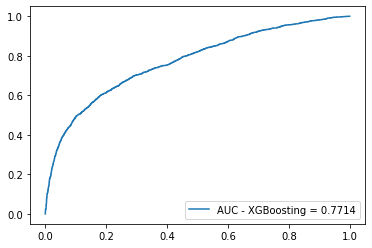

In [28]:
# Plot the precision recall curve # 4 pts
probTest = model_XGB.predict_proba(X_test)
probTest = probTest[:, 1]

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, 
                                 probTest)

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = y_test, 
                             y_score = probTest),
               decimals = 4)

# Create and show the plot
plt.plot(fpr,tpr,label="AUC - XGBoosting = " + str(auc))
plt.legend(loc=4)
plt.show()

__________________

# Part 2: Feature importance and Interpretability (50 pts)

## Feature Importance (11 pts)

In this part, we compare the variable importance constructed by mean-gini and mean-shap values.

**Task 1:** plot the variable importance plot by Entropy. (4 pts)

**Task 2:** plot the variable importance plot by mean-shap value. (3 pts)

**Task 3:** discuss the differences and why do you think it happens. (4 pts)

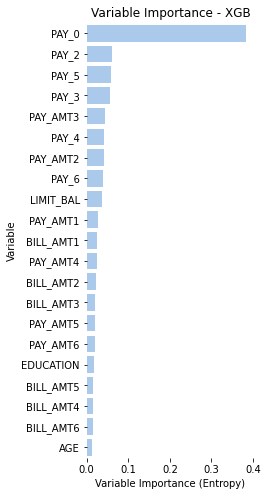

In [29]:
# Task 1: Variable importance using entropy measure #4 pts
importances = grid_xgb.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - XGB")
sns.set_color_codes("pastel")
sns.barplot(y=[X_train.columns[i] for i in indices], 
            x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Entropy)")
sns.despine(left=True, bottom=True)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


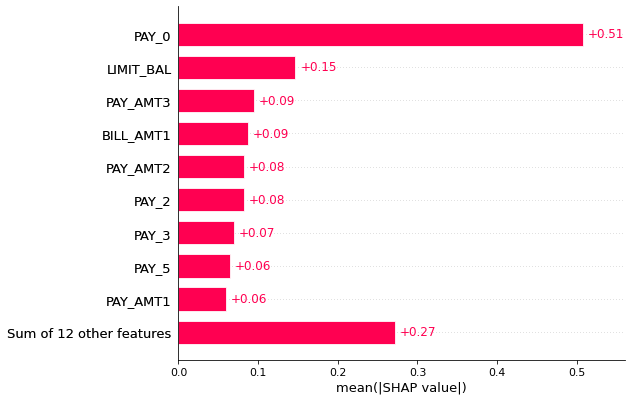

In [30]:
# Task 2: Variable importance by mean-shap values # 3 pts
explainer = shap.Explainer(grid_xgb.best_estimator_)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)

**Written Answer (4 pts)**: For both plots, the most important predictor is the repayment status in September. However, the amount of given limit in NT dollars is not a very important predictor in entropy measure but in mean-shape value it is the second most important. And the amount of payment in September in more important in the mean-shape plot. For both plot, the repayment of August, July and May is about same important in both graphs. The order of significane are differentmany of the predictors.\
The entropy method consider each importance independently. But shap calculate the average contribution per varible using game-theoretic approach that does not consider each one independently. This make the result different from the one of entropy. 

## Understanding and interpreting using SHAP values (39 pts)

**Task 1:** explain the model's predictions using SHAP for the first three cases in the dataset. What can you conclude from the feature contribution plot? (15 pts)

**Task 2:** Summarize the effects of all features by using a beeswarm plot. Report the first 3 features and interpret the results. (9 pts) 

**Task 3 :** For the variables "PAY_0","PAY_2" and "LIMIT_BAL", create a dependence scatter plot to show the effect of a single feature across the whole dataset and discuss the relationship between this feature its most highly correlated variable. (15 pts) 

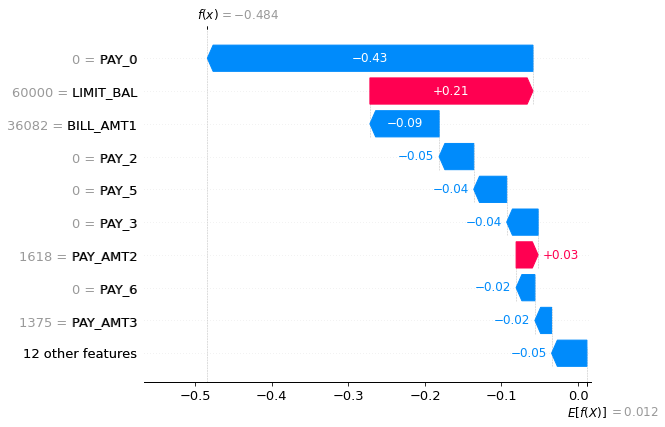

In [31]:
# Task 1:
# visualize the first prediction's explanation # 2 pts 
shap.plots.waterfall(shap_values[0])

**Written Answer (3 pts)**: \
The most effecting predictor is the repayment status of payment in september delay with 0 delay of payment. And the value is 0.42 with a negative direction. And the amount of given credits of 60000 contributes a positive direction of 0.21, as well as payment amount in August makes 0.03 positive. Whereas other factors have negative contribution. And according to the value of f(x), -0.484 gives a result in a direction towards a good result that this cutomer is a up-to-date customer. 

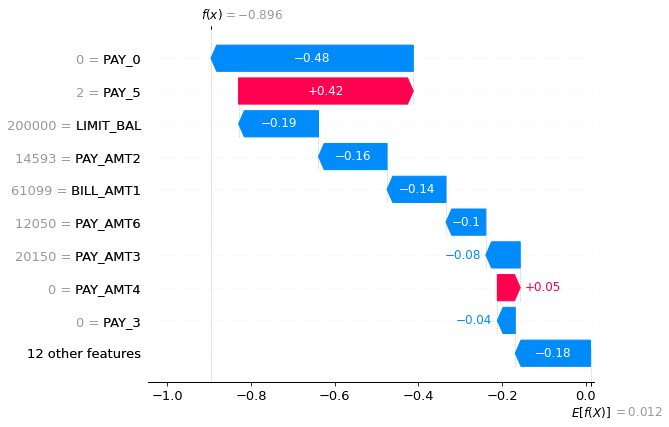

In [32]:
# visualize the second prediction's explanation # 2 pts
shap.plots.waterfall(shap_values[1])

**Written Answer (3 pts):** \
The most effecting predictor is PAY_0 at 0 with direction of negative with 0.48. And PAY_5 that has 2 months delay has a value of +0.42 contribute to the shap value. Whereas other predictors, the amount of payment in June of 0 value gives a positive value of 0.05. And all other predictors are in negative direction. And the f(x) value is -0.896 indicates that the customers is more likely to be a up-to-date customer. 

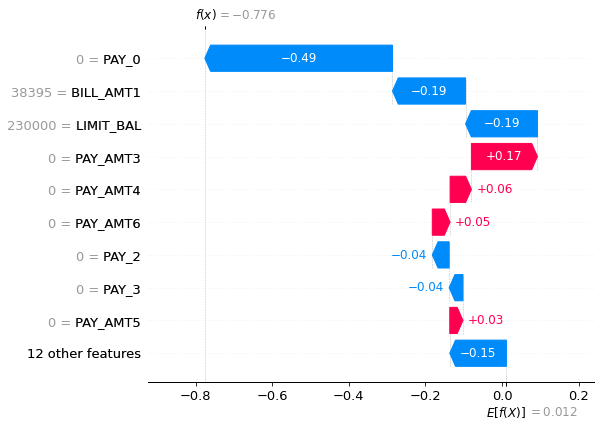

In [33]:
# visualize the third prediction's explanation # 2 pts
shap.plots.waterfall(shap_values[2])

**Written Answer (3 pts):** \
The value of number of payment in September is the most effecting predictor, same as the amount of given credit in NT dollars of 230000, has a negative value of -0.49 and -0.19, respectively. According to payment amount in July, June, May and April,  the direction of the value is positive. With other predictors, the value is negative and the total result is -0.776. This indicates that the customer is more likely to be a up-to-date customer. 

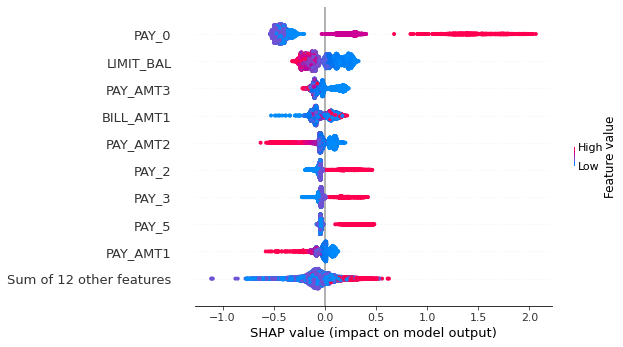

In [34]:
# Task 2: 
# summarize the effects of all the features # 3 pts
shap.plots.beeswarm(shap_values)

**Written Answer (6 pts)**: \
The most three important predictors are PAY_0, LIMIT_BAL and PAY_AMT3, which is the repayment status in September, amount of given credit and amount of payment in July. \
The plot of PAY_0 shows that there is many data gathered in SHAP value of -0.5 when the value of PAY_0 is smaller. When the PAY_0 value is larger, the SHAP value is evenly sperate out in the postive side from 1 to 2. That means paying duly it is a signal of being a up_to-date customer. And large PAY_0 value tends to direct to a default customer \
The plot of LIMIT_BAL shows that there are many data with SHAP value of 0 to -0.5 when the LIMIT_BAL value is large, the result is that the customer tends to be an up-to-date customer. There are many data clustered in 0 and 0.3 SHAP VALUE whereas the customers with lower credit given are more likely to be a default customer. \
The plot of PAY_AMT3 shows that the data with low values are clustered in the SHAP value range of -0.1 to 0.5. And with larger PAT_AMT3 value, the SHAP value is lower around -0.4. It means that people with lower payment are tend to be a default customer also there are possibilities to be a up-to-date customer. But customers with large payment amount have tend to be a up-to-date customer.


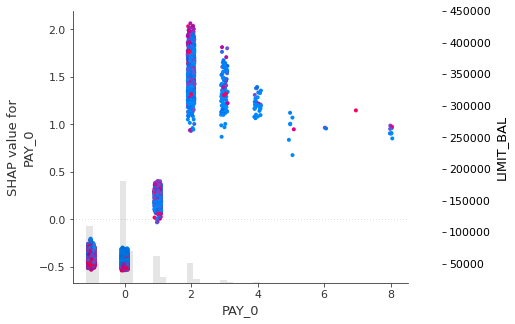

In [35]:
# Task 3:
# plot regarding PAY_0  # 2 pts
shap.plots.scatter(shap_values[:,"PAY_0"], color=shap_values)

**Written answer (3 pts):** \
According to the plot, the patterm is clearly unlinear with LIMIT_BAL predictor. PAY_0 with less or non delay payment are highly predicted towards an up-to-date customer, while the value of SHAP is only -0.5. More number of months in payment delay on September leads a default customer in about max in 2.0 shap value. The Shap value is only negative when PAY_0 is -1 or 0. At PAY_0=2, many data with different LIMIT_BAL spreate in positive direction on SHAP value. 

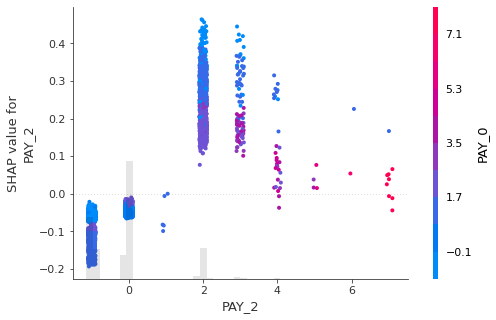

In [36]:
# plot regarding PAY_2 # 2pts
shap.plots.scatter(shap_values[:,"PAY_2"], color=shap_values)

**Written answer (3 pts):** \
PAY_2 has the same trend as the predictor PAY_0. When PAY_2 value is 2, the parameter PAY_2 only contributes towards negative when the value is 0, -1 or 1. A few customer with high pay_0 and high pay_2 still get a shap value towards a up-to-date customer. But most people with PAY_2 value of 2 are evenly spread in positive shap value from 0.1 to 0.5. And the shap value are towards negative when PAY_2 value is larger. And when PAY_2 value becomes larger, the shap value tends to decrease and change towards negative side. 


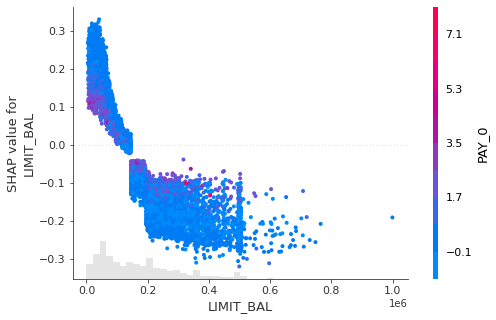

In [37]:
# plot regarding LIMIT_BAL # 2pts
shap.plots.scatter(shap_values[:,"LIMIT_BAL"], color=shap_values)

**Written answer (3 pts):** \
The relationship shows a clear non-linear shape. The amount of credit given has a opposite direction comparing to the varible PAY_0 and PAY_2. The less credit given, the shap value is more positive, and more given credits means the customer is more likely to be a up-to-date customer. The shap value range falls between -0.3 and 0.3 and most people that has trend to be up-to-date customer are having low PAY_0 value. That means thay people pay duly with more given credit is more likely to be a up-to-date customer. To be more specific, LIMIT_BAL value lower than $0.1*10^6$ are mostly consider a positive contribution of SHAP value and higher LIMIT_BAL value have negative SHAP value. 

_____________________________

# Part 3: Confounding and fairness (19 pts)

**Task 1:** 

*   Create a scatterplot of Limit_Bal and Pay0, using Gender as the hue. (3 pts)
*   Can you identify any confounding factors in these relations? Describe any issues you can find within these two variables. *Respond in Written Answer 1*.(4 pts)

**Task 2:** 

With these results, answer the following questions: 


*   Assuming you want to achieve Gender fairness. How would the independence, separation and sufficiency criteria be achieved (i.e. what does this mean for this specific model and variables)? Can these three criteria be achieved simultaneously?. *Respond in Written answer 2*. (7 pts)
*   Considering your past answers, would you take any corrective actions in these models to achieve a fairer model? What would you think is necessary to correct?. *Respond in Written Answer 3*. (5 pts)


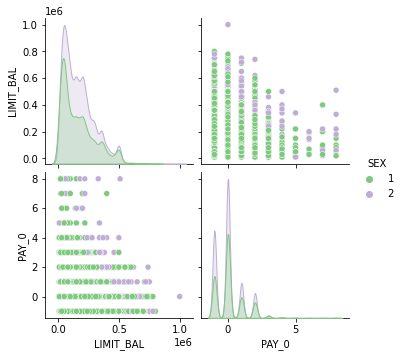

In [38]:
# Task 1:
# Pairplot #3 pts
sns.pairplot(df[['LIMIT_BAL', 'PAY_0','SEX']], hue='SEX', palette='Accent')
plt.show()

**Written Answer 1 (4 pts):** \
The confounding factor in this case is LIMIT_BAL. According to the graph, the distribution of different gender is different. Therefore it is considered a confounding factor. This means that by using LIMIT_BAL, is discriminating also by the factors, so if this is not desirable. And the problem of these two varibles is that they are mostly correlated. Most data are overlapping with both genders. And the differences between two genders are very obvious. 

**Written Answer 2 (7 pts):** \
Achieving independence in this case means that there is no relationship between the given credit and number of payment delay in the past. Seperation in this case means that we can allow correlation between the response varible default customer and  . And sufficiency means that   in the model and its calibration by group is that for any model that satisfies sufficiency that satisfies calibration by group.  \
These three criteria cannot be achieved simultaneously. Since the target here is binary, independence and seperation is mutually exclusive. And also sufficiency and seperation are mutually exclusive, it is impossible to satisfy all at once. 

**Written Answer 3 (5 pts):** \
First, a control method should be use such segmenting, interacting and averaging between all cases, or removing LIMIT_BAL from the model. We can add set of attributes to the model and interact the values with other varaibles. That is we can generate a model with and other factors. Then estimate the prediction of the model with all values for  . Lastly return a mean of all values and use the mean. It is neccessary to correct independence and the operation above will show independence. Or we can select a cut-off point using roc curve to achieve seperation .

# **Follow These Steps Before Submitting**
**Once you are finished, ensure to complete the following steps**.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.

5.  Your submission document should be saved in the form: `LastName_FirstName_Assignment9.ipynb`